# UC Merced Hack Week Tutorial : Deep Learning for Image Classification

In this tutorial, we will be covering the following topics:

1. [Introduction](#intro) 
2. [Setup & Utilities](#setup) 
3. [Working with images as arrays and tensors](#images)  
4. [Machine learning background for image classification](#classifier_background) 
5. [Image classification in 5 steps with PyTorch](#classifier_script) 
6. [Packaging the classifier in an object-oriented wrapper](#classifier_class)
7. [Tutorial Wrap-up / Q & A](#conclusion)
8. [Setting up a group bitbucket/github](#conclusion)




<a id='intro'></a>
## Introduction

Image classification is a task in the Computer Vision domain that takes in an image as input and outputs a label for that image. Deep learning is the most effective modern method for modeling this task. In this notebook, we will overview how to perform multi-class image classification in Python using the PyTorch library. The intention is to give you a broad overview of this particular task of classification and inspire you to explore the vast fields of visual recognition and computer vision at large. 

This Notebook is based onon the Image Classification tutorial produced by LLNL Data Scientists Luke Jaffe and Cindy Gonzalez.

### Breaking down the problem

#### Evaluation: What should our model do when we deploy it?

![Eval Diagram](https://myconfluence.llnl.gov/download/attachments/293571119/eval_diagram.jpg)


#### Training: How do we improve the accuracy of our model?

![Train Diagram](https://myconfluence.llnl.gov/download/attachments/293571119/train_diagram.jpg)

Gradient descent diagram from: https://blog.clairvoyantsoft.com/the-ascent-of-gradient-descent-23356390836f

Neural network diagram from: http://neuralnetworksanddeeplearning.com/chap1.html 

This Notebook covers each of these topics, and provide links for learning about the material in greater detail.

<a id='setup'></a>
## Setup & Utilities

First thing's first, let's import all of the packages and setup some variables that we will need to run the code in this notebook. Read the comments of each cell if you have questions on any of the lines below.

### Setting up Jupyter Notebook

In [2]:
# Automatically reload modules
%load_ext autoreload
%autoreload 2

# Show matplotlib plots inline
%matplotlib inline

# Select which GPU device to use (if any)
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


### Importing packages needed

In [3]:
# System libraries
import os
import sys

# Object-oriented utility library
import collections

# Image processing library
import PIL
from PIL import Image, ImageOps

# Numerical computing libraries
import numpy as np
import pandas as pd

# Neural network libraries
import torch
import torchvision

# Plotting library
import matplotlib.pyplot as plt

# Progress bar library
import progressbar

# Widget libraries
from IPython.display import display
import ipywidgets as widgets
from ipywidgets import interact

### Setting up constants needed

In [4]:
# Color constants
BLACK = (0, 0, 0)
WHITE = (255, 255, 255)
GRAY = (220,220,220)
GRAY2 = (231,230,230)

# Directory where datasets will be downloaded
DEFAULT_DATASET_DIR = './data'

### Setting up image display utility functions

In [27]:
def hstitch(images, spacing=5, border=5, spacing_color=BLACK, border_color=BLACK):
    widths, heights = zip(*(i.size for i in images))

    total_width = sum(widths)+spacing*(len(widths)-1)
    max_height = max(heights)

    new_im = Image.new('RGB', (total_width, max_height), color=spacing_color)

    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset,0))
        x_offset += im.size[0] + spacing

    if border > 0:
        new_im = ImageOps.expand(new_im, border=border, fill=border_color)

    return new_im

def vstitch(images, spacing=5, border=5, spacing_color=BLACK, border_color=BLACK):
    widths, heights = zip(*(i.size for i in images))

    total_height = sum(heights)+spacing*(len(heights)-1)
    max_width = max(widths)

    new_im = Image.new('RGB', (max_width, total_height), color=spacing_color)

    y_offset = 0
    for im in images:
        new_im.paste(im, (0, y_offset))
        y_offset += im.size[1] + spacing

    if border > 0:
        new_im = ImageOps.expand(new_im, border=border, fill=border_color)

    return new_im

def build_mosaic(img_list, rows, cols, clip=True, spacing=5, imborder=3, totborder=5, spacing_color=BLACK, 
                 border_color=BLACK):
    if rows*cols < len(img_list) and clip:
        img_list = img_list[:rows*cols]
    elif rows*cols > len(img_list):
        raise Exception(
            '# images in list is less than width x height = {} x {} = {} < {}'.format(
            rows, cols, rows*cols, len(img_list)))

    # Reshape 
    img_mat = np.array(img_list, dtype=object).reshape(rows, cols).tolist()

    # Border images
    if imborder > 0:
        new_img_mat = []
        for img_row in img_mat:
            new_row = []
            for img in img_row:
                img = ImageOps.expand(img, border=imborder)
                new_row.append(img)
            new_img_mat.append(new_row)
        img_mat = new_img_mat

    # First create rows
    row_list = [hstitch(img_row, spacing=spacing, border=0, spacing_color=spacing_color, border_color=border_color) for img_row in img_mat]

    m = vstitch(row_list, spacing=spacing, border=0, spacing_color=spacing_color, border_color=border_color)

    if totborder > 0:
        m = ImageOps.expand(m, border=totborder)

    return m

<a id='images'></a>
## Working with images as arrays and tensors

### How does a computer "see" an image to be able to perform classification on it?

An image is made up of pixels, which is a single number that represents the intensity of that particular area of an image. Let's consider a black-and-white image. Use the slider below to see what each pixel value represents as an image.

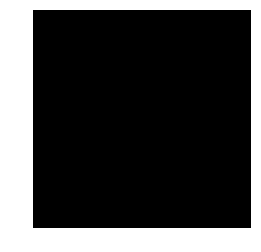

<function __main__.display_img_tsr>

In [28]:
def display_img_tsr(x):
    img_tsr = torch.rand(128, 128)
    img_tsr.fill_(x)
    img_arr = img_tsr.numpy()
    plt.axis('off')
    plt.imshow(img_arr, cmap='gray', vmin=0, vmax=255)
    plt.show()
    
interact(display_img_tsr, x=widgets.IntSlider(min=0, max=255, step=1, continuous_update=True))

Now, let's move on to a color image. Color images are comprised of three bands-- a red, green, and blue band. A pixel value in each of the bands represents the intensity of that color in the overall image. So, a value of 0 for the red band would represent the absence of red in an image and a value of 255 would represent an intensely red image. The same is true for the blue and green bands.

To give you some sense of what each pixel looks like at different red, green, and blue values, use the sliders below to adjust the intensity of each band independently. Some of the color combinations may suprise you!

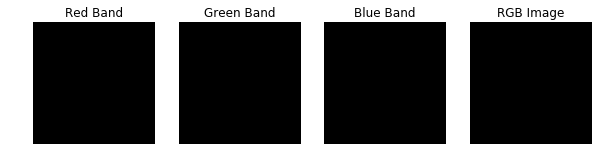

<function __main__.display_img_tsr>

In [29]:
def display_img_tsr(red, green, blue):
    fig, axs = plt.subplots(1, 4, figsize=(10, 10))

    r = torch.zeros(128, 128, 3)
    g = torch.zeros(128, 128, 3)
    b = torch.zeros(128, 128, 3)
    img_tsr = torch.zeros(128, 128, 3)
    
    r[:, :, 0].fill_(red)
    g[:, :, 1].fill_(green)
    b[:, :, 2].fill_(blue)
    
    img_tsr[:, :, 0].fill_(red)
    img_tsr[:, :, 1].fill_(green)
    img_tsr[:, :, 2].fill_(blue)

    
    axs[0].imshow(r/255)
    axs[0].axis('off')
    axs[0].title.set_text('Red Band')
    axs[1].imshow(g/255)
    axs[1].axis('off')
    axs[1].title.set_text('Green Band')
    axs[2].imshow(b/255)
    axs[2].axis('off')
    axs[2].title.set_text('Blue Band')
    axs[3].imshow(img_tsr/255)
    axs[3].axis('off')
    axs[3].title.set_text('RGB Image')
    plt.show()
    
interact(
    display_img_tsr, 
    red=widgets.IntSlider(min=0, max=255, step=1, continuous_update=True), 
    green=widgets.IntSlider(min=0, max=255, step=1, continuous_update=True),
    blue=widgets.IntSlider(min=0, max=255, step=1, continuous_update=True)
)

### Loading an image dataset for use

To allow us to train a model in this tutorial, we have chosen to use the CIFAR dataset. Let's download the dataset as follows:

In [30]:
# The torchvision library has several image datasets built-in, including CIFAR10
trainset = torchvision.datasets.CIFAR10(root=DEFAULT_DATASET_DIR, train=True, download=True)
testset = torchvision.datasets.CIFAR10(root=DEFAULT_DATASET_DIR, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


The CIFAR dataset has 10 classes with 6000 images per class. Each image is of size 32 x 32. Here is a visualization of the classes with samples of each class:

plane


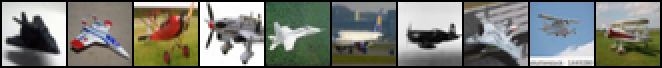

car


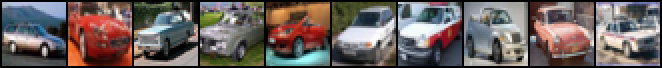

bird


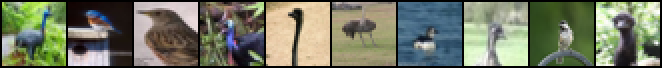

cat


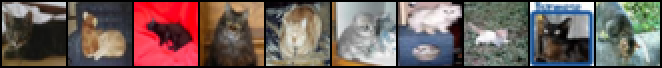

deer


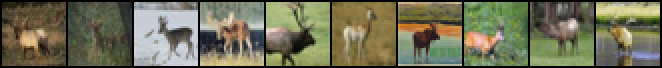

dog


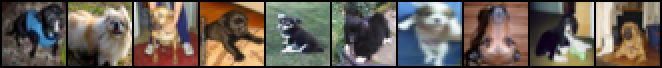

frog


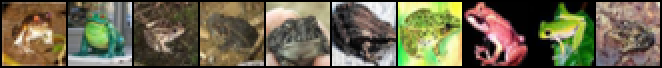

horse


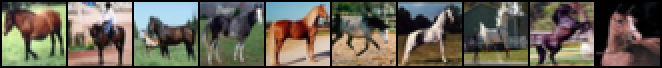

ship


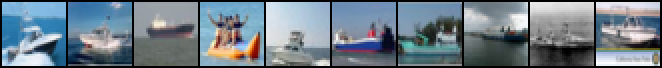

truck


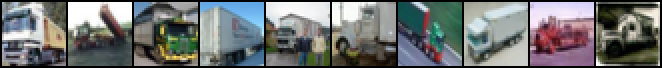

In [31]:
# These are the 10 types of objects in the CIFAR10 dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# This loop will display 10 examples from each class in the CIFAR10 dataset
for i, c in enumerate(classes):
    print(c)
    imgs = []
    for item in trainset:
        if item[1] == i:
            imgs.append(item[0].resize((64,64))) # For visibility, double the size
            if len(imgs) == 10:
                break
    display(hstitch(imgs, spacing=2, border=2))

Let's take a look at just one image from the CIFAR10 dataset...

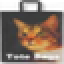

In [32]:
img = trainset[3000][0]
img.resize((64,64))

What do the red, green, and blue color channels look like for this image?

In [33]:
df = pd.DataFrame(1-np.array(img)[:, :, 0])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Reds')

In [34]:
df = pd.DataFrame(1-np.array(img)[:, :, 1])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greens')

In [35]:
df = pd.DataFrame(1-np.array(img)[:, :, 2])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Blues')

Understanding how an image can be interpreted as an array, we are now ready to set up a simple neural network to understand the basics of training a classifier.

<a id='classifier_background'></a>
## Machine Learning Background for Image Classification

This is intended as a primer on some of the core concepts that will be used in our classifier code. If you haven't seen it before, it's ok if you don't immediately understand each part. The subject is very deep, and we have included some links to learn more later if you are interested.

At a high level, the two topics we will discuss are neural networks and optimization.

### Neural Networks

The model we will use to build our image classifier is a neural network. 

#### Neurons

A neural network, also known as an artifical neural network, is a collection of artifical neurons connected in a graph, usually a directed acyclic graph (a DAG). These neurons can be thought of as a filter that is looking for relevant features, either of an image or of the previous layer in the network. Below is an example of a neural network.

![image.png](http://neuralnetworksanddeeplearning.com/images/tikz1.png)
<center> Source: http://neuralnetworksanddeeplearning.com/chap1.html </center>

Generally, neural networks take in an input and run that input through a series of groups of neurons. Each group of neurons is known as a "layer", where the first layer is known as the input layer (takes the input) and the last layer is known as the output layer (outputs something that can be used for classification, etc.) All layers in between the input and output layers are known as hidden layers even though they are not actually hidden. They are simply a group of neurons which are connected to neurons in the previous layer and neurons in the next layer.

Each neuron takes in some inputs, does some calculation on those inputs, caches outputs for later parameter updates, and then pushes outputs on to the next layer. We'll go more into how they update their parameters later.

#### Convolutional Neural Networks

Now, the picture that we have painted so far for a basic neural network just won't scale well for images. Images have a lot of pixels. In the examples that we have talked about so far (the CIFAR dataset), the input would be 32x32x3 = 3072 parameters per neuron in the first layer of the network. There are typically hundreds of neurons in one layer. In addition, most images are not as small as 32x32. Many times, the images are larger than 200x200x3 = 120,000 parameters per neuron in the first layer and hundreds of neurons in each layer which can lead to millions of parameters, if not more. This can lead to an unmanageable neural network with a huge number of parameters.

Enter the Convolutional Neural Network (let's call these ConvNets for short). ConvNets have neurons that take a (often) 3D input-- so a neuron that takes a length, width, and depth measurement which translates well to images. As we discussed before, RGB images are three stacked arrays (one for each the red, green, and blue bands) and an image can then can be translated to a 3D array with height, width, and some number of channels. 

To display the difference, take a look at the below:

#### Regular Neural Network
![image.png](https://cs231n.github.io/assets/nn1/neural_net2.jpeg)
<center> Source: https://cs231n.github.io/convolutional-networks/#layers </center>


#### Convolutional Neural Network
![image.png](https://cs231n.github.io/assets/cnn/cnn.jpeg)
<center> Source: https://cs231n.github.io/convolutional-networks/#layers </center>

The uniqueness of this network and why it is so good for processing images lies in its basic pieces/parts. A ConvNet is composed of three distinct layers types: 
1. Convolutional layer
2. A pooling layer
3. Non-linear activation

We're going to go through the basics of these quickly and we will include resources if you want to do some studying on your own.

#### Convolutional Layer
The convolutional layer takes a chunk of an image and multiplies it by a fixed matrix to detect features. Each neuron can represent a feature so you would do this repeatedly for each feature. Take a look at this [interactive tool to learn about convolutions](https://setosa.io/ev/image-kernels/).

#### Example
![convolution.png](https://raw.githubusercontent.com/hiromis/notes/master/lesson6/32.png)


#### Pooling Layer
Next, the pooling layer takes a larger image and reduces it down in a way that still preserves the most important information. The most common type of pooling is max pooling, which takes patches from the convolved image and picks the largest value from the patch and uses that to represent the image.

![pooling.png](https://miro.medium.com/max/512/1*ReZNSf_Yr7Q1nqegGirsMQ@2x.png)
<center> Source: https://towardsdatascience.com/applied-deep-learning-part-4-convolutional-neural-networks-584bc134c1e2 </center>

#### Non-Linear Layer
Finally, a non-linear activation allows the ConvNets to learn a non-linear function, which is very important. An [important theoretical result](https://en.wikipedia.org/wiki/Universal_approximation_theorem) is that a neural network with a single hidden layer (of arbitrary width) can represent any well-behaved function. This helps us understand why a non-linearity is necessary, but not sufficient for learning a model for a problem such as classification.

The most common non-linear layer is the rectified linear unit layer (ReLU) which makes all negative values 0:

$$ \text{ReLU}(x) = \max(0, x) $$


##### Example
![ReLU.png](https://i.pinimg.com/originals/8a/13/09/8a130915c66d23d37b0a5dc9fd8baf38.jpg)

#### Why do convolutional layers work well?

Convolutional layers are effective for image learning for a few reasons:

#### Spatial invariance
ConvNets are designed to be spatially invariant. In other words, they are not sensitive to the position (translation) of objects in images. The ConvNet turns pixels into features via convolutions and pooling. The features in an image will be detected no matter their original position in the image.

#### Hierarchy of features
ConvNets process features in a hierarchical way, much like the mammalian brain. Here is a really great visual to help us explain this:

![hierarchy.png](https://miro.medium.com/max/2400/1*Ji5QhY9QXBlpNNLH4qAcNA.png)
<center> Source: https://towardsdatascience.com/identifying-traffic-signs-with-deep-learning-5151eece09cb </center>

In the earlier layers, the neurons learn simple features such as edges. As we move through the network, the features become more defined, with mid-layers learning patterns and later layers learning more complex semantic constructs (such as physical objects you might recognize).

If you are interested in learning more about how a ConvNet works, check out any of these resources: 
1. [Stanford's CS231n: Convolutional Neural Networks for Visual Recognition class notes](https://cs231n.github.io/convolutional-networks/#layers)
2. [CNNs from different viewpoints](https://medium.com/impactai/cnns-from-different-viewpoints-fab7f52d159c)
3. [How do Convolutional Neural Networks work?](https://e2eml.school/how_convolutional_neural_networks_work.html)
4. The course content from Andrew Ng's deep learning specialization from Coursera is available on YouTube. Review C4W1L01 - C4W1L11. [Here's the playlist related to Convolutional Neural Networks](https://www.youtube.com/playlist?list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF)
5. [Interactive tool to learn about convolutions](https://setosa.io/ev/image-kernels/)
6. [Paper on how mammilian brains process features](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1363130/)

### Optimization

How do we tune the parameters of our model to classify images more accurately?

#### Selecting a surrogate for classification: Logistic Regression
In a classification network, the number of outputs is equal to the number of classes in our dataset. For the CIFAR10 dataset, this is 10 classes. When the 10 raw outputs come out of the network, the output corresponding to the correct class should be higher, and the outputs corresponding to the other classes should be lower. The next step is usually to convert our outputs to a probability distribution. To do so, we can use the model of logistic regression. The logistic sigmoid function squashes $x \in \mathbb{R}$ to $f(x) \in (0, 1)$.

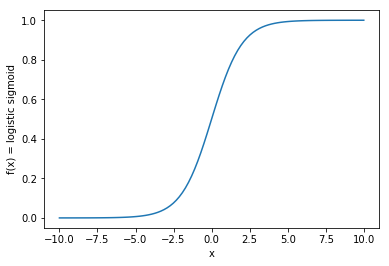

In [36]:
# Plot the logistic sigmoid function
x = np.linspace(-10, 10, 100)
f = lambda x: 1 / (1 + np.exp(-x))
plt.plot(x, f(x))
plt.xlabel('x')
plt.ylabel('f(x) = logistic sigmoid')
plt.show()

The multiclass extension of the logistic function is called the softmax function.
Let the output of our network be $x \in \mathbb{R}^c$. Then the softmax function is defined as, 

$$ f(x)_i = \frac{e^{x_i}}{\sum_{j=1}^{c} e^{x_j}} $$

Intuitively, this will squash the output of our network into a probability distribution: each class is assigned a probability between 0 and 1, and the c (=10) probabilties sum to 1.

In [37]:
# Set printing options for numpy
np.set_printoptions(precision=3, suppress=True)

# Create a fake raw output of our network
network_output_raw = np.random.randn(10)
print('Raw network outputs:', network_output_raw)

# Define the softmax function
def softmax_function(x):
    numerator = np.exp(x)
    denominator = numerator.sum()
    return numerator / denominator

# Run the softmax function on our network output to get probabilities
network_output_prob = softmax_function(network_output_raw)
print('Network outputs converted to probabilities:', network_output_prob)
print('Sum of probabilities: {:.1f}'.format(network_output_prob.sum()))

('Raw network outputs:', array([-1.177, -1.851, -1.378, -0.259, -1.437, -0.605,  0.116, -0.212,
       -0.492, -0.46 ]))
('Network outputs converted to probabilities:', array([0.057, 0.029, 0.046, 0.142, 0.044, 0.1  , 0.206, 0.149, 0.112,
       0.116]))
Sum of probabilities: 1.0


Now, we want to reward the network for outputting a high probability for the correct class, and punish it for outputting a low probability for the correct class. A popular choice of "objective" function to accomplish this goal is the cross-entropy loss, defined as:

$$ L_{CE}(x, \text{true_class}) = -\log (\text{softmax}(x)[\text{true_class}]) $$

This takes the probability of the true class, as computed by the softmax function, and converts it to a quantity that we need to reduce in order to increase the probability.

$$ \text{prob}_{\text{softmax}} \in (0, 1) $$
$$ \log(\text{prob}_{\text{softmax}}) \in (-\infty, 0) $$
$$ -\log(\text{prob}_{\text{softmax}}) \in (0, \infty) $$

In order to get the probability of the true class to be close to 1 for a given image, we need to get the cross-entropy loss for that class close to 0. But how do we update our model to make this happen? We can use the gradient descent algorithm.

Note: Logistic regression is a very deep subject in machine learning theory, and there are many theoretical reasons why we use the logistic function and cross-entropy loss, aside from the fact that they produce intuitive outputs. Here is one resource on Logistic Regression and its connection to a Naive Bayes classifier: https://www.cs.cmu.edu/~tom/mlbook/NBayesLogReg.pdf

#### Gradient Descent 

Our goal in training our network would be to minimize this loss function. Specifically, we want to find values for our weights and biases in the model that can minimize the loss function. To do this, we can use the gradient descent algorithm. 

The gradient descent update rule for a univariate function $f(x)$ is as follows:
$$
x^{t+1} = x^t - \alpha f'(x^t)
$$

To help us understand this update, let's look at a simple example function, before extending to loss minimization:
$$
f(x) = x^2
$$
$$
\Rightarrow f'(x) = 2x
$$

So the specific update for this $f(x)$ would be:
$$
x^{t+1} = x^t - 2 \alpha x^t
$$
And we start the optimization procedure at some $x^0$, which can be selected at random for this example.

Intuitively: at each timestep $t$, we evaluate the derivative of the function at the current $x$. This gives us the slope of the function. If we know the slope, we know which way is down on the function. We can then take a step of some chosen size in that new direction. Graphically:


![gradient_descent](https://miro.medium.com/max/875/1*G1v2WBigWmNzoMuKOYQV_g.png)
<center> Source: https://blog.clairvoyantsoft.com/the-ascent-of-gradient-descent-23356390836f </center>


To control how quickly we move down the function's surface, we will need to define a learning rate: the value multiplied by the gradient of the function to determine the magnitude of the step we will take. The learning rate is a so-called hyperparameter that you can fine-tune to get the most efficient training.  If the learning rate is too large, gradient descent could diverge (the loss value gets increasingly larger until it approaches infinity). If the learning rate is too small, the algorithm could fail to make progress or settle in a local minimum and never reach a global minimum of the function.

#### Gradient descent with a model

In practice, we need to run gradient descent on a model with parameters, not just a univariate function. In this case, we might have some function $L(w; x)$, where $x$ is the data, and $w$ is the parameters of the model. In this case, the gradient descent update could be written as

$$
w^{t+1} = w^t - \alpha \nabla L(w^t; x)
$$

We will not review the exact form of this update for cross-entropy loss, but here is one resource with more information: https://www.stat.cmu.edu/~cshalizi/uADA/12/lectures/ch12.pdf

#### Stochastic Minibatch Gradient Descent

How do we apply the gradient descent algorithm to real data? One option is compute gradients of the model parameters for the entire dataset at the same time. But in practice, due to optimization properties and memory constraints, we randomly sample "minibatches" from the dataset, and take a step after computing gradients for each minibatch. This is called stochastic minibatch gradient descent, abbreviated as SGD. Pseudo-code for training with SGD could look like the following:
```
# Iterate through all images in the dataset
for _ in num_batches(dataset):
    # Randomly sample a minibatch of images
    batch_images, batch_labels = random_sample(dataset, num_images_per_batch)
    
    # Run the model on the images to get our raw outputs
    model_outputs = run_model(model, batch_images)
    
    # Compute the loss for these raw outputs given the true labels
    batch_loss = compute_loss(model_outputs, batch_labels)
    
    # Compute gradients of the model parameters with respect to the loss
    batch_grads = compute_gradients(model, batch_loss)
    
    # Update the model parameters using the computed gradients and the learning rate
    gradient_descent(model, batch_grads, learning_rate)
```
We will see later on how to implement this in PyTorch.

#### The Backpropagation Algorithm

The backpropagation algorithm is used to efficiently compute gradients for all parameters in the network using dynamic programming and the calculus chain rule.

![Backprop Figure](https://www.guru99.com/images/1/030819_0937_BackPropaga1.png)

Figure from: https://www.guru99.com/backpropogation-neural-network.html

Resource on the backpropagation algorithm: https://page.mi.fu-berlin.de/rojas/neural/chapter/K7.pdf

Thankfully, PyTorch (and other neural networks libraries) handle this for us, using some variation of an "autograd"
package. This handles all the calculus and dynamic programming behind the scenes, so all you have to do is specify the functions you want to compute.

Automatic differentiation survey: https://arxiv.org/abs/1502.05767

PyTorch autograd tutorial: https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html

#### Gradient Descent for Large Convolutional Neural Networks

In practice, convolutional neural networks have millions or even billions of parameters. Surprisingly, stochastic gradient descent still works on these large models, since the loss surface is more regular than you would expect. This is a property of the model architecture, the objective function, and the data itself.

![Loss Landscape](https://myconfluence.llnl.gov/download/attachments/293571119/loss_landscape_figure.png)

Figure from, "Visualizing the Loss Landscape of Neural Nets", Li, Xu, et al.: https://papers.nips.cc/paper/2018/file/a41b3bb3e6b050b6c9067c67f663b915-Paper.pdf

A paper studying why SGD is effective: https://arxiv.org/abs/1509.01240

#### Training, validation, and testing: does our model generalize?

To ensure that our model will work on new data (and not just the training set), we need to carve out part of our data for "validation" and "testing". We use the validation set to tune hyperparameters (such as learning rate) during training, and we run the model on the test set once when we are done training, to report final performance statistics.

![Training vs. Testing](https://lh6.googleusercontent.com/uuKkYCYun1Ky6C7_GwEtv0gNdaoHyx0WTXiM8jvGOQqGx75gIRVhx1to7OapyGDbOsmKyAl9Eyi5RC-atbk6AXukkA7UBXA-NutKcAdHaTGDsWSzNGyBaCBMvVu1HLuU1Wm6TxWb)

Figure from: http://www.dailysmarty.com/posts/setting-up-test-validation-and-training-sets-of-data

Now that we've touched on the basics, let's see how these concepts are implemented in PyTorch for training and testing an image classifier:

<a id='classifier_script'></a>
## Image classification in 5 steps with PyTorch
#### STEP 0: SETUP
Not needed in this notebook, but useful if you want to move this to a standalone script.

```
# Global imports
import os
import torch
import torchvision
import argparse
import progressbar

# Get arguments from the user
parser = argparse.ArgumentParser()
parser.add_argument('--dataset_dir', type=str, default=os.path.join('..', '..', '.datasets'))
parser.add_argument('--dataset_name', type=str, default='fashion_mnist')
parser.add_argument('--batch_size', type=int, default=128)
parser.add_argument('--learning_rate', type=float, default=1e-3)
parser.add_argument('--num_epochs', type=int, default=10)
args = parser.parse_args()
```

#### Alternate setup just for this notebook

In [5]:
# Object for handling args
Args = collections.namedtuple('Args', [
    'dataset_dir',
    'dataset_name',
    'batch_size',
    'learning_rate',
    'num_epochs',
])

# Instance of arg-handling object:
# Try modifying batch_size, learning_rate, and num_epochs
args = Args(
    dataset_dir=DEFAULT_DATASET_DIR,
    dataset_name='cifar10',
    batch_size=128,
    learning_rate=1e-2,
    num_epochs=10,
)

#### STEP 1: LOAD DATA

In [11]:
# Create a transform object to pre-process the image data
transform = torchvision.transforms.Compose([
    # ToTensor converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] 
    # to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].
    torchvision.transforms.ToTensor()
    # Normally, we would also normalize the data to have mean=0, SD=1
])

# Create the dir to store the dataset in before downloading it
dataset_path = os.path.join(args.dataset_dir, args.dataset_name)
if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)

# Instantiate dataset objects for the CIFAR10 dataset (train and test)
trainset = torchvision.datasets.CIFAR10(dataset_path, train=True, transform=transform, download=True)
testset = torchvision.datasets.CIFAR10(dataset_path, train=False, transform=transform, download=False)

print(len(trainset[0][0][0]))

# Instantiate dataloader objects to shuffle, batch, and iterate through the dataset
# *It is important to shuffle the training set, so the optimizer sees more variation
trainloader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=args.batch_size, shuffle=False)

Files already downloaded and verified
32


#### STEP 2: CREATE MODEL

In [40]:
# Create simple model with 2 fully-connected / linear layers
model = torch.nn.Sequential(
    # First layer takes input that is size of the unraveled image
    # - The layer has 100 neurons, and each neuron has 32x32x3 weights + 1 bias
    # - Output is 100 "features"
    torch.nn.Linear(32*32*3, 100),
    # We use a ReLU activation as our non-linearity
    torch.nn.ReLU(inplace=True),
    # Final linear layer takes 100 features and outputs 10 "scores" (1 for each class)
    # - We will need to convert these scores to probabilities separately by applying the softmax function
    torch.nn.Linear(100, 10)
)

#### STEP 3: CREATE OBJECTIVE AND OPTIMIZER

In [41]:
# Use the cross entropy loss function/objective/criterion
objective = torch.nn.CrossEntropyLoss()

# Use the SGD optimizer with user input learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=args.learning_rate)

#### STEP 4: TRAIN AND TEST MODEL

In [42]:
# Function to train for one epoch
def run_epoch(dataloader, train_flag=True):
    # Put model in train or eval mode (important for BatchNorm and Dropout)
    model.train() if train_flag else model.eval()
    # Statistic accumulators
    total_loss, correct, total = 0, 0, 0
    # Use progressbar inside this block
    with progressbar.ProgressBar(max_value=len(dataloader)) as bar:
        # Iterate throught the dataset in batches
        for batch_idx, (batch_data, batch_labels) in enumerate(dataloader):
            # Zero out stored gradients during training
            if train_flag:
                optimizer.zero_grad()
            # Reshape data for model
            # - converts the data from size torch.Size([128, 3, 32, 32])
            # - to size torch.Size([128, 3072])
            batch_data = batch_data.view(batch_data.size(0), -1)
            # Put the image batch through the model
            # - output has size torch.Size([128, 10])
            batch_output = model(batch_data)
            # Compute loss function with model output and labels
            # - loss has size torch.Size([]) (it is a scalar)
            loss = objective(batch_output, batch_labels)
            # Update model during training
            if train_flag:
                # Backpropagate gradients (w.r.t. loss) through the computation graph during training
                loss.backward()
                # Update weights using stored gradients during training
                optimizer.step()
            # Compute loss
            total_loss += loss.item()
            # Compute accuracy
            _, predicted = batch_output.max(1)
            total += batch_labels.size(0)
            correct += predicted.eq(batch_labels).sum().item()
            # Update progress bar
            bar.update(batch_idx)
    # Compute statistics over the epoch
    epoch_loss = total_loss / (batch_idx + 1)
    epoch_acc = correct / total
    print('{} results: loss={:.3f}, acc={:.3f}'.format('Train' if train_flag else 'Test', epoch_loss, epoch_acc))

#### STEP 5: THE TRAINING LOOP

In [43]:
# Test for one epoch before training to see accuracy of the randomly initialized model
with torch.no_grad():
    run_epoch(testloader, train_flag=False)

100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Test results: loss=2.320, acc=0.000


In [44]:
# Train and test for num_epochs
for epoch in range(args.num_epochs):
    print('Epoch {}'.format(epoch))
    # Train for one epoch
    run_epoch(trainloader, train_flag=True)
    # Test for one epoch: do not compute gradients when testing
    with torch.no_grad():
        run_epoch(testloader, train_flag=False)

N/A% (0 of 391) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Epoch 0


100% (391 of 391) |######################| Elapsed Time: 0:00:27 Time:  0:00:27
  2% (2 of 79) |                         | Elapsed Time: 0:00:00 ETA:   0:00:05

Train results: loss=2.103, acc=0.000


100% (79 of 79) |########################| Elapsed Time: 0:00:05 Time:  0:00:05
N/A% (0 of 391) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Test results: loss=1.991, acc=0.000
Epoch 1


100% (391 of 391) |######################| Elapsed Time: 0:00:26 Time:  0:00:26
  2% (2 of 79) |                         | Elapsed Time: 0:00:00 ETA:   0:00:05

Train results: loss=1.925, acc=0.000


100% (79 of 79) |########################| Elapsed Time: 0:00:05 Time:  0:00:05
N/A% (0 of 391) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Test results: loss=1.889, acc=0.000
Epoch 2


100% (391 of 391) |######################| Elapsed Time: 0:00:26 Time:  0:00:26
  2% (2 of 79) |                         | Elapsed Time: 0:00:00 ETA:   0:00:05

Train results: loss=1.860, acc=0.000


100% (79 of 79) |########################| Elapsed Time: 0:00:04 Time:  0:00:04
N/A% (0 of 391) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Test results: loss=1.838, acc=0.000
Epoch 3


100% (391 of 391) |######################| Elapsed Time: 0:00:37 Time:  0:00:37
  1% (1 of 79) |                         | Elapsed Time: 0:00:00 ETA:  00:00:00

Train results: loss=1.817, acc=0.000


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02
N/A% (0 of 391) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Test results: loss=1.795, acc=0.000
Epoch 4


100% (391 of 391) |######################| Elapsed Time: 0:00:30 Time:  0:00:30
  2% (2 of 79) |                         | Elapsed Time: 0:00:00 ETA:   0:00:04

Train results: loss=1.782, acc=0.000


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02
N/A% (0 of 391) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Test results: loss=1.763, acc=0.000
Epoch 5


100% (391 of 391) |######################| Elapsed Time: 0:00:30 Time:  0:00:30
  2% (2 of 79) |                         | Elapsed Time: 0:00:00 ETA:   0:00:04

Train results: loss=1.753, acc=0.000


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02
N/A% (0 of 391) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Test results: loss=1.742, acc=0.000
Epoch 6


100% (391 of 391) |######################| Elapsed Time: 0:00:30 Time:  0:00:30
  2% (2 of 79) |                         | Elapsed Time: 0:00:00 ETA:   0:00:05

Train results: loss=1.728, acc=0.000


100% (79 of 79) |########################| Elapsed Time: 0:00:03 Time:  0:00:03
N/A% (0 of 391) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Test results: loss=1.713, acc=0.000
Epoch 7


100% (391 of 391) |######################| Elapsed Time: 0:00:27 Time:  0:00:27
  2% (2 of 79) |                         | Elapsed Time: 0:00:00 ETA:   0:00:05

Train results: loss=1.706, acc=0.000


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02
N/A% (0 of 391) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Test results: loss=1.699, acc=0.000
Epoch 8


100% (391 of 391) |######################| Elapsed Time: 0:00:27 Time:  0:00:27
  2% (2 of 79) |                         | Elapsed Time: 0:00:00 ETA:   0:00:04

Train results: loss=1.684, acc=0.000


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02
  0% (3 of 391) |                        | Elapsed Time: 0:00:00 ETA:   0:00:14

Test results: loss=1.675, acc=0.000
Epoch 9


100% (391 of 391) |######################| Elapsed Time: 0:00:30 Time:  0:00:30
  2% (2 of 79) |                         | Elapsed Time: 0:00:00 ETA:   0:00:04

Train results: loss=1.665, acc=0.000


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Test results: loss=1.662, acc=0.000


<a id='classifier_class'></a>
## Packaging the classifier in an object-oriented wrapper

### Classifier Model: Convolutional Neural Network

First, we need to define a basic model. Read the comments below to walk you through the model.

In [45]:
# Declare CIFAR10Model class
class BasicModel(torch.nn.Module):
    """
    Simple model which takes 32x32 inputs and produces
    score values for each of 10 classes for each element.
    Model adapted from:
    https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
    """
    def __init__(self):
        super(BasicModel,self).__init__()
        # Features
        self.layer_list = torch.nn.ModuleList([
            # 2d Convolution, 1 channel in, 6 channels out, kernel size 6
            # - Conv layer will have 6 filters of size 6x6x3 weights + 1 bias
            torch.nn.Conv2d(3, 6, 6),
            # Rectified Linear Unit activation, inplace=True saves a small amount of memory
            torch.nn.ReLU(inplace=True),
            # 2d Max Pooling, kernel size 2, stride 2
            # - Downsamples both width and height of our feature map by factor of 2
            torch.nn.MaxPool2d(2, 2),
            # 2d Convolution, 6 channels in, 16 channels out, kernel size 5
            # - Conv layer will have 16 filters of size 5x5x6 weights + 1 bias
            torch.nn.Conv2d(6, 16, 5),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(2, 2),
        ])
        # Classifier
        self.classifier = torch.nn.Sequential(
            # Fully-Connected, 256 elements in, 120 elements out
            # - The layer has 120 neurons, and each neuron has 256 weights + 1 bias
            torch.nn.Linear(256, 120),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(120, 84),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(84, 10),
        )

    def forward(self, x):
        """
        Pass one batch of image data through the model.
        Return batch of score values corresponding to each class.
        Input size: (batch_size, 1, 32, 32)
        Output size: (batch_size, 10)
        """
        # Shape of data is: (batch_size, 1, 32, 32)
        for layer in self.layer_list:
            x = layer(x)
        # Shape of data is: (batch_size, 16, 4, 4)
        x = x.view(x.size(0), -1)
        # Shape of data is: (batch_size, 256)
        x = self.classifier(x)
        # Shape of data is: (batch_size, 10)
        return x

Next, we use that model to create a trainable classifier.

In [46]:
class Classifier:
    def __init__(self, dataset_dir=DEFAULT_DATASET_DIR, dataset_name='cifar10', batch_size=128, 
                 learning_rate=1e-3, device='cpu'):
        # Store parameters
        self.device = device

        # Create a transform object to pre-process the image data
        train_transform = torchvision.transforms.Compose([
            torchvision.transforms.RandomCrop(32, padding=4),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])

        test_transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])

        # Create the dir to store the dataset in before downloading it
        dataset_path = os.path.join(dataset_dir, dataset_name)
        if not os.path.exists(dataset_path):
            os.makedirs(dataset_path)

        # Instantiate dataset objects for the CIFAR10 dataset (train and test)
        # - Downloads the dataset if it has not already been downloaded
        self.trainset = torchvision.datasets.CIFAR10(dataset_path, train=True, transform=train_transform, 
                                                     download=True)
        self.testset = torchvision.datasets.CIFAR10(dataset_path, train=False, transform=test_transform, 
                                                    download=False)

        # Store the class names
        self.class_name_list = ('plane', 'car', 'bird', 'cat', 'deer',
                'dog', 'frog', 'horse', 'ship', 'truck')

        # Instantiate dataloader objects to shuffle, batch, and iterate through the dataset
        self.trainloader = torch.utils.data.DataLoader(self.trainset, batch_size=batch_size, shuffle=True)
        self.testloader = torch.utils.data.DataLoader(self.testset, batch_size=batch_size, shuffle=False)

        # Create model
        self.model = BasicModel()

        # Put model on GPU if available
        self.model = self.model.to(self.device)
        if self.device == 'cuda':
            # Make model data parallel and put it in multiple GPUs if available
            self.model = torch.nn.DataParallel(self.model)
            # Use cuDNN
            torch.backends.cudnn.benchmark = True

        # Use the cross entropy loss function/objective/criterion
        self.criterion = torch.nn.CrossEntropyLoss()

        # Use the Adam optimizer with user input learning rate
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)

        # Widgets for progressbar during training and testing
        # - reports loss and accuracy at every update
        self.widgets = [
            ' [', progressbar.Percentage(), '] ',
            progressbar.Bar(),
            ' [', progressbar.DynamicMessage('loss'), '] ',
            ' [', progressbar.DynamicMessage('acc'), '] ',
            ' [', progressbar.Timer(), '] ',
            ' [', progressbar.ETA(), '] ',
        ]

    # Get some random sample images from the trainset
    def sample(self, n, seed=0):
        # Random seed
        np.random.seed(seed)
        # Create a random index to shuffle the train set
        rand_idx = np.arange(len(self.trainset.train_data))
        np.random.shuffle(rand_idx)
        # Get a list of the raw tensors stored in the trainset
        arr_list =  self.trainset.train_data[rand_idx][:n]
        # Convert the raw tensors to PIL Image objects
        img_list = [Image.fromarray(arr) for arr in arr_list]
        # Return the list of PIL Image objects
        return img_list

    # Get some random sample images from the testset and run them through the model
    def sample_eval(self, n, seed=0):
        # Random seed
        np.random.seed(seed)
        # Create a random index to shuffle the train set
        rand_idx = np.arange(len(self.testset.test_data))
        np.random.shuffle(rand_idx)
        # Get a list of the raw tensors stored in the trainset
        arr_list =  self.testset.test_data[rand_idx][:n]
        label_list = np.array(self.testset.test_labels)[rand_idx][:n]
        # Convert the raw tensors to PIL Image objects
        img_list = [Image.fromarray(arr) for arr in arr_list]
        # Get a list of the raw tensors stored in the trainset
        batch_data = torch.stack([self.trainset.transform(img) for img in img_list], dim=0)
        # Put model in eval mode
        self.model.eval()
        # Run batch through model
        with torch.no_grad():
            batch_output = self.model(batch_data)
            # Get softmax scores for each element
            sm_list = torch.nn.functional.softmax(batch_output, dim=-1).cpu().numpy()
        # Return the list of PIL Image objects
        return img_list, label_list, sm_list

    # Function to train for one epoch
    def train(self):
        """
        Train for one epoch of the dataloader using the model, criterion, and optimizer.
        """
        # Put model in train mode (important for BatchNorm and Dropout)
        self.model.train()
        # Statistic accumulators
        total_loss = 0.0
        correct = 0
        total = 0
        avg_loss, acc = None, None
        # Set up widgets for progress bar
        _mode = ['Train:']
        _widgets = _mode + self.widgets
        # Use progressbar inside this block
        with progressbar.ProgressBar(max_value=len(self.trainloader), widgets=_widgets) as bar:
            # Iterate throught the dataset in batches
            for batch_idx, (batch_data, batch_labels) in enumerate(self.trainloader):
                # Put the images and labels on GPU if available
                batch_data, batch_labels = batch_data.to(self.device), batch_labels.to(self.device)
                # Zero out stored gradients
                self.optimizer.zero_grad()
                # Put the image batch through the model
                batch_output = self.model(batch_data)
                # Compute loss function with model output and labels
                loss = self.criterion(batch_output, batch_labels)
                # Backpropagate gradients (w.r.t. loss) through the computation graph
                loss.backward()
                # Update weights using stored gradients
                self.optimizer.step()

                # Compute loss
                total_loss += loss.item()
                avg_loss = total_loss / (batch_idx + 1)

                # Compute accuracy
                _, predicted = batch_output.max(1)
                total += batch_labels.size(0)
                correct += sum(predicted.eq(batch_labels))
                acc = correct / total

                # Update progress bar
                bar.update(batch_idx, loss=avg_loss, acc=acc)

        return avg_loss, acc

    # Function to test for one epoch
    def test(self):
        """
        Test for one epoch of the dataloader using the model.
        """
        # Put model in eval mode (important for BatchNorm and Dropout)
        self.model.eval()
        # Statistic accumulators
        total_loss = 0.0
        correct = 0
        total = 0
        avg_loss, acc = None, None
        # Set up widgets for progress bar
        _mode = ['Test:']
        _widgets = _mode + self.widgets
        # DO NOT compute gradients for any computation inside this block
        # - temporarily sets all requires_grad = False
        with torch.no_grad():
            # Use progressbar inside this block
            with progressbar.ProgressBar(max_value=len(self.testloader), widgets=_widgets) as bar:
                # Iterate throught the dataset in batches
                for batch_idx, (batch_data, batch_labels) in enumerate(self.testloader):
                    # Put the images and labels on GPU if available
                    batch_data, batch_labels = batch_data.to(self.device), batch_labels.to(self.device)
                    # Put the image batch through the model
                    batch_output = self.model(batch_data)
                    # Compute loss function with model output and labels
                    loss = self.criterion(batch_output, batch_labels)

                    # Compute total loss and average loss per batch
                    total_loss += loss.item()
                    avg_loss = total_loss / (batch_idx + 1)

                    # Compute accuracy
                    _, predicted = batch_output.max(1)
                    total += batch_labels.size(0)
                    correct += sum(predicted.eq(batch_labels))
                    acc = correct / total

                    # Update progress bar
                    bar.update(batch_idx, loss=avg_loss, acc=acc)

        return avg_loss, acc

Instantiate the classifier object that we built in classifier_module.

In [47]:
# Instantiate a classifier object
classifier = Classifier(device='cuda')


Files already downloaded and verified


Visualize examples from the train set to get an idea of what they look like.

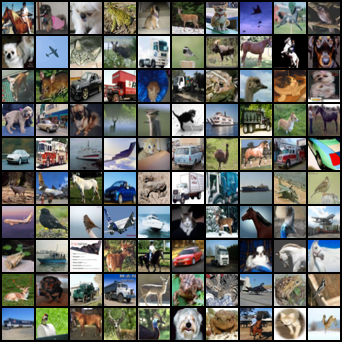

In [48]:
# Sample 100 images from the train set
img_list = classifier.sample(100)
# Combine these images in a mosaic
img_mosaic = build_mosaic(img_list, 10, 10, spacing=0, imborder=1, totborder=1)
# Display the image mosaic
display(img_mosaic)

Here, we include a utility function to visualize an image and the softmax score computed for that image by the classifier model.

In [49]:
# A function to plot an image and the model's softmax scores for that image
def plot_img_softmax(img, label, sm):
    # Get the true and predicted label name strings
    true_label = classifier.class_name_list[label]
    pred_label_idx = sm.argmax()
    pred_label = classifier.class_name_list[pred_label_idx]
    
    # Subplots to plot image and scores side by side
    fig, (img_ax, sm_ax) = plt.subplots(1, 2, figsize=(6, 3))
    
    # Plot the image
    img_ax.imshow(img, cmap='gray')
    img_ax.set_axis_off()
    img_ax.set_title('True label: {}\nPredicted label: {}'.format(true_label, pred_label))

    # Plot the softmax scores
    sm_ax.barh(range(len(sm)), sm)
    sm_ax.set_title('Softmax Probabilities')
    sm_ax.set_xlim(0.0, 1.0)
    sm_ax.set_yticks(range(len(sm)))
    sm_ax.set_yticklabels(classifier.class_name_list)

    # Use tight_layout so labels don't overlap image
    plt.tight_layout()

We use this utility function to visualize 3 examples from the test set.

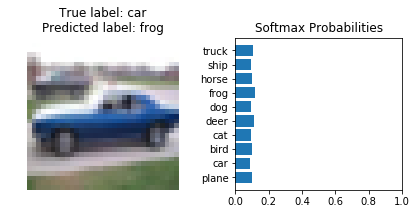

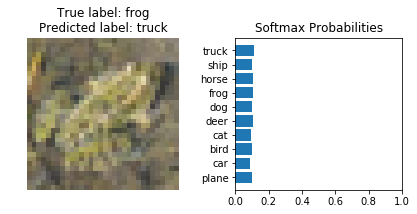

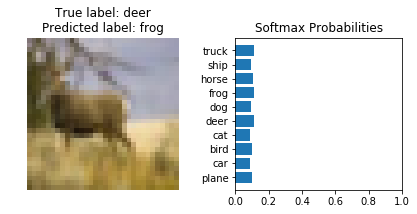

In [50]:
# Sample 3 images from the test set and run them through the model
img_list, label_list, sm_list = classifier.sample_eval(3, seed=2)
# Display each image with softmax scores for each class
for img, label, sm in zip(img_list, label_list, sm_list):
    plot_img_softmax(img, label, sm)

This cell shows a standard pattern for training with the classifier, and retaining accuracy and loss statistics.
These statistics can then be visualized as a function of training epoch using matplotlib.

In [51]:
# Training variables
num_epochs = 10
# Lists to hold statistics from training
train_loss_list, test_loss_list = [], []
train_acc_list, test_acc_list = [], []
# Train and test the model for num_epochs
for i in range(num_epochs):
    # Train
    train_loss, train_acc = classifier.train()
    # Test
    test_loss, test_acc = classifier.test()
    # Save statistics from the epoch
    train_loss_list.append(train_loss), test_loss_list.append(test_loss)
    train_acc_list.append(train_acc), test_acc_list.append(test_acc)

Train: [100%] || [loss:   1.87]  [acc: ------]  [Elapsed Time: 0:00:18]  [Time:  0:00:18] 
Test: [100%] || [loss:   1.62]  [acc:      1]  [Elapsed Time: 0:00:02]  [Time:  0:00:02] 
Train: [100%] || [loss:   1.61]  [acc:      1]  [Elapsed Time: 0:00:18]  [Time:  0:00:18] 
Test: [100%] || [loss:   1.46]  [acc: ------]  [Elapsed Time: 0:00:02]  [Time:  0:00:02] 
Train: [100%] || [loss:   1.51]  [acc:      1]  [Elapsed Time: 0:00:18]  [Time:  0:00:18] 
Test: [100%] || [loss:   1.37]  [acc: ------]  [Elapsed Time: 0:00:02]  [Time:  0:00:02] 
Train: [100%] || [loss:   1.44]  [acc:      2]  [Elapsed Time: 0:00:18]  [Time:  0:00:18] 
Test: [100%] || [loss:   1.34]  [acc: ------]  [Elapsed Time: 0:00:02]  [Time:  0:00:02] 
Train: [100%] || [loss:   1.39]  [acc:      1]  [Elapsed Time: 0:00:18]  [Time:  0:00:18] 
Test: [100%] || [loss:   1.29]  [acc:      1]  [Elapsed Time: 0:00:02]  [Time:  0:00:02] 
Train: [100%] || [loss:   1.36]  [acc:      2]  [Elapsed Time: 0:00:18]  [Time:  0:00:18] 
Test

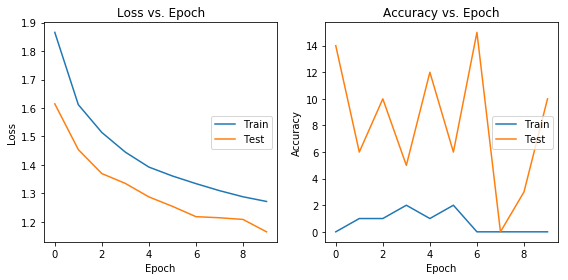

In [52]:
# Plot loss and accuracy side by side
fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(8, 4))

# Plot train and test loss
loss_ax.plot(range(num_epochs), train_loss_list, label='Train')
loss_ax.plot(range(num_epochs), test_loss_list, label='Test')
loss_ax.legend(loc='center right')
loss_ax.set_xlabel('Epoch')
loss_ax.set_ylabel('Loss')
loss_ax.set_title('Loss vs. Epoch')

# Plot train and test accuracy
acc_ax.plot(range(num_epochs), train_acc_list, label='Train')
acc_ax.plot(range(num_epochs), test_acc_list, label='Test')
acc_ax.legend(loc='center right')
acc_ax.set_xlabel('Epoch')
acc_ax.set_ylabel('Accuracy')
acc_ax.set_title('Accuracy vs. Epoch')

# Tight layout so labels don't overlap axes
plt.tight_layout()

Finally, we use the example visualization function to show softmax scores for examples with the trained model.
Ideally, these scores will be close to 1.0 for the correct class (but not likely for this simple training procedure).

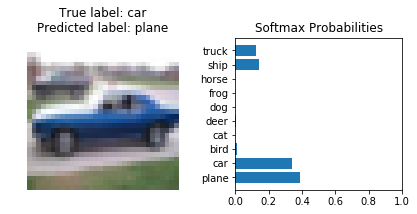

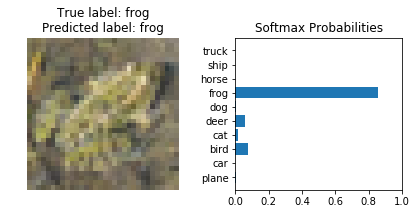

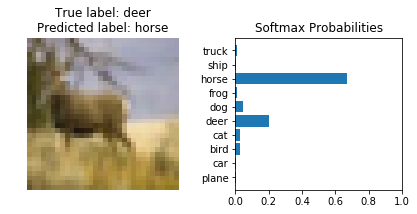

In [53]:
# * Now that we have trained for a bit, we can try this step again
# Sample 3 images from the test set and run them through the model
img_list, label_list, sm_list = classifier.sample_eval(3, seed=2)
# Display each image with softmax scores for each class
for img, label, sm in zip(img_list, label_list, sm_list):
    plot_img_softmax(img, label, sm)

### So, how well did we do?

Not very! The best published model has 99.7% accuracy on this dataset: https://paperswithcode.com/sota/image-classification-on-cifar-10

But the procedure for training that model is very similar. Researchers have tweaked each step in our process to get better results:
- The model will be much deeper, and have a specialized architecture e.g., ResNet: https://arxiv.org/abs/1512.03385
- The optimization procedure will decrease the learning rate, gradually or in steps, and could take specialized steps instead of basic SGD: https://arxiv.org/pdf/2010.01412v2.pdf
- The data will be heavily augmented, to try to cover all possible variations on appearance of the images
    - See the torchvision.transforms library: https://pytorch.org/docs/stable/torchvision/transforms.html
    - or the albumentations library: https://albumentations.ai/
- And many other things!


### What other classification datasets are there besides CIFAR10?
- The first dataset used for classifying images with a ConvNet was MNIST: http://yann.lecun.com/exdb/mnist/
    - Link to (later version of) the original paper by Yann LeCun et al.: http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf
- The most important benchmark dataset for image classification is ImageNet (specifically the version from the 2012 challenge): http://image-net.org/challenges/LSVRC/2012/index
    - AlexNet was the first effective deep learning model, trained on this dataset: http://www.cs.toronto.edu/~kriz/imagenet_classification_with_deep_convolutional.pdf
- torchvision supports several datasets, shown here: https://pytorch.org/vision/0.8/datasets.html

### What visual recognition problems can we solve besides classification?
- Object detection: draw a rectangular box around all objects in an image
    - Paper for original version of an important object detection model (R-CNN): https://arxiv.org/abs/1311.2524
- Segmentation: classify every pixel in an image
    - Paper for important image segmentation model (FCN): https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Long_Fully_Convolutional_Networks_2015_CVPR_paper.pdf
- Image retrieval: return all images in a database similar to an input image
    - Paper for important image retrieval model: https://ieeexplore.ieee.org/document/1640964
- These problems applied to video
    - Action detection in video: https://arxiv.org/abs/1411.6031
- These problems in a different image domain (Infrared, Lidar)
- These problems with very few training examples
    - Method to pre-train network so it can quickly learn new task with few examples (meta-learning): https://arxiv.org/abs/1703.03400
- Applications such as self-driving cars: https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf

### What neural network libraries are there besides PyTorch?
- The most popular alternative to PyTorch is TensorFlow: https://www.tensorflow.org/
    - Commonly used with the Keras library: https://keras.io/
- There are also a number of helper / wrapper libraries for PyTorch:
    - fastai: https://www.fast.ai/
    - PyTorch Lightning: https://www.pytorchlightning.ai/
    - and other libraries in the PyTorch "ecosystem": https://pytorch.org/ecosystem/

<a id='conclusion'></a>
## Q&A

- Questions about machine learning / deep learning theory
- Questions about computer vision
- Questions about PyTorch